In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


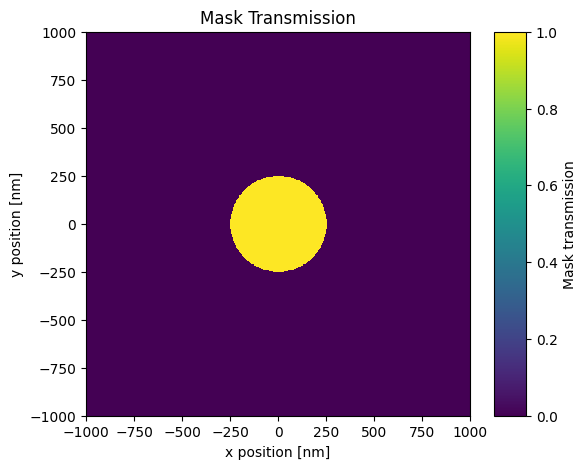

In [33]:
#Define the chromium dot size in nanometers
dot_size = 250.

#Define the mask XY grid
#Siunce we compute FT, better to chose a 2^n number of points
grid=512
x_support=np.linspace(-1000.,1000.,grid)
y_support=np.linspace(-1000.,1000.,grid)

x_grid,y_grid = np.meshgrid(x_support,y_support,indexing='xy')

#Compute the pixel size in nanometers
dx=2000./grid
dy=2000./grid

#Define the mask, 1 for glass, 0 for chromium
length = np.sqrt(x_grid**2 + y_grid**2)
mask = np.where(length <= dot_size,1,0) 


#Plot
plt.title('Mask Transmission')
plt.imshow(mask, interpolation='none', extent = [np.min(x_support) , np.max(x_support), np.min(y_support) , np.max(y_support)])
plt.axis('scaled')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.xlabel('x position [nm]')
plt.ylabel('y position [nm]')
cax = plt.axes([0.80, 0.1, 0.05, 0.8])
plt.colorbar(cax=cax,label = 'Mask transmission')
plt.show()

In [4]:
#Computation of the mask TF and its frequency support
mask_ft = np.fft.fftshift( np.fft.fft2(mask) )

#Do not forget the pixel size d when creating the frequency support
freq_x = np.fft.fftshift( np.fft.fftfreq(grid,d=dx) )
freq_y = np.fft.fftshift( np.fft.fftfreq(grid,d=dy) )


##Analytical Fourier Transform
#mask_ana_ft = np.zeros((freq_x.size,freq_y.size),dtype=complex)
#for pi,p in enumerate(freq_x):
#    for qi,q in enumerate(freq_y):
#        for ii,i in enumerate(x_support):
#            for ji,j in enumerate(y_support):
#                mask_ana_ft[pi][qi] += mask[ii][ji] * np.exp(-1j*2*np.pi*(p*i+q*j)) *dx*dy

                                                        


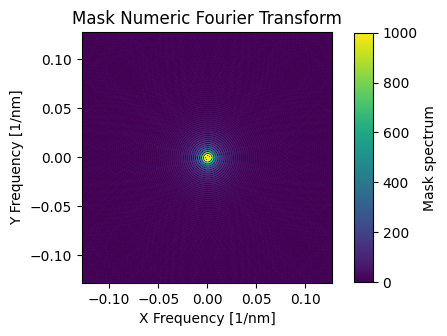

In [22]:
#Plot
plt.subplot(1,2,1)
plt.subplots_adjust(left=0.125, bottom=0.0, right=1.3, top=0.8, wspace=1.0, hspace=1.0)
plt.title('Mask Numeric Fourier Transform')
plt.imshow(np.abs(mask_ft), interpolation='none', extent = [np.min(freq_x) , np.max(freq_x), np.min(freq_y) , np.max(freq_y)],vmin=0., vmax=1000.)
plt.xlabel('X Frequency [1/nm]')
plt.ylabel('Y Frequency [1/nm]')

#plt.subplot(1,2,2)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=1.0, hspace=1.0)
#plt.title('Mask Analytic Fourier Transform')
#plt.imshow(np.abs(mask_ana_ft), interpolation='none', extent = [np.min(freq_x) , np.max(freq_x), np.min(freq_y) , np.max(freq_y)])
#plt.xlabel('X Frequency [1/nm]')
#plt.ylabel('Y Frequency [1/nm]')
#cax = plt.axes([1.04, 0.33, 0.03, 0.34])
#plt.colorbar(cax=cax,label = 'Mask spectrum')

cax = plt.axes([0.55, 0.14, 0.03, 0.52])
plt.colorbar(cax=cax,label = 'Mask spectrum')

plt.show()


In [56]:
def compute_abbe(sigma, NA, wavelength, mask_ft, frq_x, frq_y, x_support, y_support, vmin, vmax, make_plots=False):
    #Define the frequency grid
    frq_X,frq_Y = np.meshgrid(frq_x,frq_y,indexing='xy')
    
    #Define the effective source points of the circular source
    frq_L = np.sqrt(frq_X**2 + frq_Y**2)
    source_points = np.where(frq_L <=sigma*NA/wavelength, 1, 0) 

    #Initialisation of the aerial image as single precision
    aerial_image = np.zeros_like(mask_ft,dtype='float32')
    
    #Compute all source points contribution to the aerial image
    for qi,q in enumerate(frq_x):
        for pi,p in enumerate(frq_y):
            
            #Abort current loop if no light source exist at current frequency
            if source_points[qi][pi]==0:
                continue
            
            #shift of the frequency grid relative to the current source point frequency
            freq_msk_shftX = frq_X - source_points[qi][pi] * frq_X[qi][pi]
            freq_msk_shftY = frq_Y - source_points[qi][pi] * frq_Y[qi][pi]
            
            #Shifted transfer function of the projection lens
            pupil_shifted = np.where( np.sqrt(freq_msk_shftX**2 + freq_msk_shftY**2) <=NA/wavelength, 1, 0)
            
            #Shifted transfer function of the projection lens is applied to the mask spectrum
            mask_lpf = np.multiply(mask_ft, pupil_shifted)
            
            #Add the contribution of the current src point to the overall aerial image
            aerial_image += np.abs(np.fft.ifft2(mask_lpf))**2
                
    # Normalisation with number of source points
    aerial_image /=np.sum(source_points)
    
    #Plotting
    if make_plots:
        fig=plt.figure()
        plt.title(f'Aerial Image - {np.sum(source_points)} source points')
        plt.imshow(aerial_image, interpolation='none', extent = [np.min(x_support) , np.max(x_support), np.min(y_support) , np.max(y_support)],vmin=vmin, vmax=1.)
        plt.xlabel('x position [nm]')
        plt.ylabel('y position [nm]')
        cax = plt.axes([0.85, 0.11, 0.05, 0.77])
        plt.colorbar(cax=cax,label = 'Intensity [au]')
        plt.show()
    else:
        return aerial_image
        

In [57]:
#Uncomment to use interactive mode
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
interact(compute_abbe, sigma=(0.0,1.0,0.01),NA=(0.2,0.6,0.01), wavelength=[('436nm', 436), ('365nm', 365),('248nm', 248), ('193nm', 193)],mask_ft=fixed(mask_ft),frq_x=fixed(freq_x),frq_y=fixed(freq_y),x_support=fixed(x_support),y_support=fixed(y_support),vmin=fixed(0.), vmax=fixed(1.), make_plots=fixed(True));



interactive(children=(FloatSlider(value=0.5, description='sigma', max=1.0, step=0.01), FloatSlider(value=0.4, …

In [36]:
# 'L' Shape mask creation using x_support, y_support, x_grid, y_grid to be the region [-1000.,1000] devided by grid
rectang1 = np.where(x_grid >= -500., 1, 0) + np.where(x_grid <= -400., 1, 0) + np.where(y_grid >= -500., 1, 0) + np.where(y_grid <=  500., 1, 0)
rectang1 = np.where(rectang1 == 4, 1, 0)
rectang2 = np.where(x_grid >= -500., 1, 0) + np.where(x_grid <= 500., 1, 0) + np.where(y_grid >= -500., 1, 0) + np.where(y_grid <=  -400., 1, 0)
rectang2 = np.where(rectang2 == 4, 1, 0)
maskL = np.where(rectang1 + rectang2 > 0, 1, 0)


#Computation of the mask_L TF. using freq_x, freq_y
maskL_ft = np.fft.fftshift( np.fft.fft2(maskL) )
freq_X, freq_Y = np.meshgrid(freq_x, freq_y)

# 'L' shape mask aerial image
aerial_image_L=compute_abbe(sigma=0.8,NA=0.5,wavelength=193.,mask_ft=maskL_ft,frq_x = freq_x, frq_y = freq_y, x_support = x_support, y_support=y_support,vmin=0., vmax=1. )




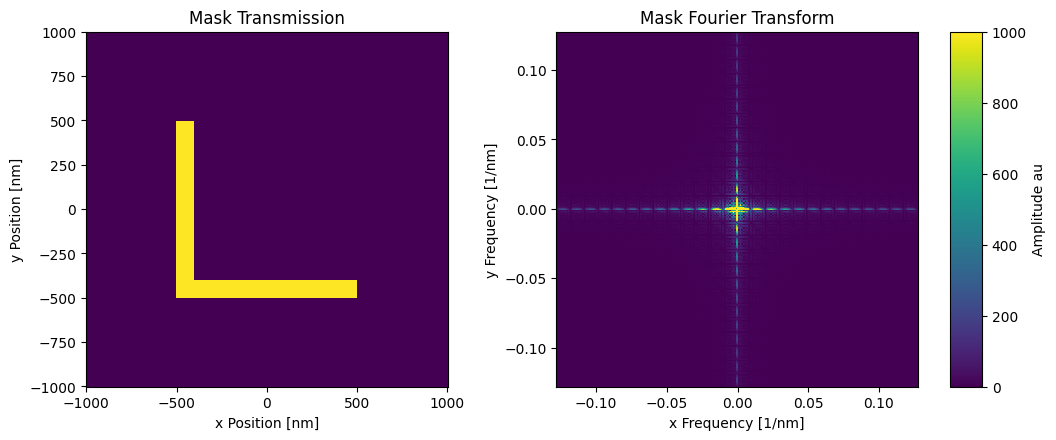

In [53]:
#Plot

#Mask
plt.subplot(1,2,1)
plt.title('Mask Transmission')
plt.pcolor(x_grid,y_grid, maskL, vmin=0., vmax=1.)
#plt.imshow(maskL,interpolation='none', extent = [np.min(x_support) , np.max(x_support), np.min(y_support) , np.max(y_support)],vmin=0., vmax=1.)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=0.74, wspace=0.3, hspace=0.3)
plt.xlabel('x Position [nm]')
plt.ylabel('y Position [nm]')
#cax = plt.axes([0.9, 0.2, 0.05, 0.6])
#plt.colorbar(cax=cax,label = 'Transmission')


# FT plot
plt.subplot(1,2,2)
plt.title('Mask Fourier Transform')
plt.pcolor(freq_X,freq_Y, np.abs(maskL_ft), vmin=0., vmax=1000.)
#plt.imshow(np.abs(maskL_ft),interpolation='none', extent = [np.min(freq_x) , np.max(freq_x), np.min(freq_y) , np.max(freq_x)],vmin=0., vmax=1000.)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=0.74, wspace=0.3, hspace=0.3)
plt.xlabel('x Frequency [1/nm]')
plt.ylabel('y Frequency [1/nm]')
cax = plt.axes([1.35, 0.0, 0.05, 0.74])
plt.colorbar(cax=cax,label = 'Amplitude au')
plt.show()


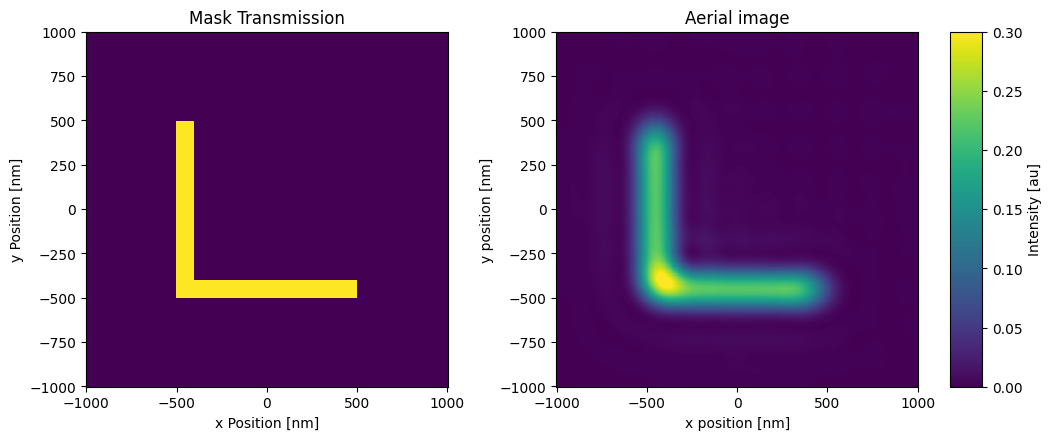

In [54]:
#Mask
plt.subplot(1,2,1)
plt.title('Mask Transmission')
plt.pcolor(x_grid,y_grid, maskL, vmin=0., vmax=1.0)
#plt.imshow(maskL,interpolation='none', extent = [np.min(x_support) , np.max(x_support), np.min(y_support) , np.max(y_support)],vmin=0., vmax=1.)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=0.74, wspace=0.3, hspace=0.3)
plt.xlabel('x Position [nm]')
plt.ylabel('y Position [nm]')
#cax = plt.axes([0.9, 0.2, 0.05, 0.6])
#plt.colorbar(cax=cax,label = 'Transmission')

#aerial image
plt.subplot(1,2,2)
plt.title('Aerial image')
plt.pcolor(x_grid,y_grid,aerial_image_L,vmin=0., vmax=0.3)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=0.74, wspace=0.3, hspace=0.3)
#plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.ylabel('y position [nm]')
cax = plt.axes([1.35, 0.0, 0.05, 0.74])
plt.colorbar(cax=cax,label = 'Intensity [au]')

plt.show()

In [29]:
#OPC for the 'L' shaped mask
#Reinforce each vertex with 64nm size square. However, subtract same square at the vertex on the corner.
r=80.
square1 = np.where(x_grid >= -400., 1, 0) + np.where(x_grid <= -400.+r, 1, 0) + np.where(y_grid >= 500., 1, 0) + np.where(y_grid <= 500.+r, 1, 0)
square1 = np.where(square1 == 4, 1, 0)
square2 = np.where(x_grid >= -500.-r, 1, 0) + np.where(x_grid <= -500., 1, 0) + np.where(y_grid >= 500., 1, 0) + np.where(y_grid <= 500.+r, 1, 0)
square2 = np.where(square2 == 4, 1, 0)
square3 = np.where(x_grid >= -500.-r, 1, 0) + np.where(x_grid <= -500., 1, 0) + np.where(y_grid >= -500.-r, 1, 0) + np.where(y_grid <= -500., 1, 0)
square3 = np.where(square3 == 4, 1, 0)
square4 = np.where(x_grid >= 500., 1, 0) + np.where(x_grid <= 500.+r, 1, 0) + np.where(y_grid >= -500.-r, 1, 0) + np.where(y_grid <= -500., 1, 0)
square4 = np.where(square4 == 4, 1, 0)
square5 = np.where(x_grid >= 500., 1, 0) + np.where(x_grid <= 500.+r, 1, 0) + np.where(y_grid >= -400., 1, 0) + np.where(y_grid <= -400.+r, 1, 0)
square5 = np.where(square5 == 4, 1, 0)
square6 = np.where(x_grid >= -400.-r, 1, 0) + np.where(x_grid <= -400., 1, 0) + np.where(y_grid >= -400.-r, 1, 0) + np.where(y_grid <= -400., 1, 0)
square6 = np.where(square6 == 4, -1, 0)
maskL_opc = np.where(maskL + square1 + square2 + square3 + square4 + square5 > 0, 1, 0) + square6

#fourier transform of opc maskL
maskL_opc_ft = np.fft.fftshift( np.fft.fft2(maskL_opc) )

# 'L' shape mask aerial image
aerial_image_L_opc=compute_abbe(sigma=0.8,NA=0.5,wavelength=193.,mask_ft=maskL_opc_ft,frq_x = freq_x, frq_y = freq_y, x_support = x_support, y_support=y_support,vmin=0., vmax=1. )


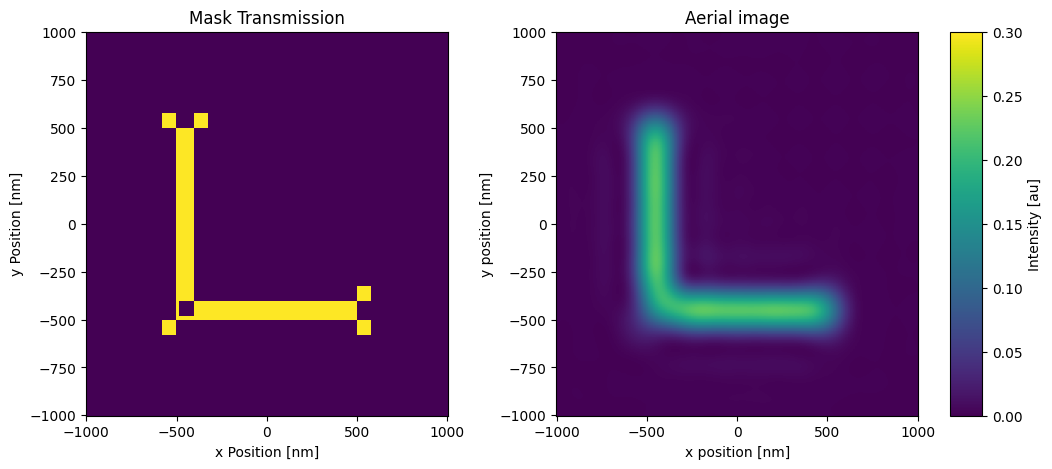

In [30]:
#Mask
plt.subplot(1,2,1)
plt.title('Mask Transmission')
plt.pcolor(x_grid,y_grid, maskL_opc, vmin=0., vmax=1.)
#plt.imshow(maskL,interpolation='none', extent = [np.min(x_support) , np.max(x_support), np.min(y_support) , np.max(y_support)],vmin=0., vmax=1.)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=0.74, wspace=0.3, hspace=0.3)
plt.xlabel('x Position [nm]')
plt.ylabel('y Position [nm]')
#cax = plt.axes([0.9, 0.2, 0.05, 0.6])
#plt.colorbar(cax=cax,label = 'Transmission')

#aerial image
plt.subplot(1,2,2)
plt.title('Aerial image')
plt.pcolor(x_grid,y_grid,aerial_image_L_opc,vmin=0., vmax=0.3)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=0.74, wspace=0.3, hspace=0.3)
#plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.ylabel('y position [nm]')
cax = plt.axes([1.35, 0.0, 0.05, 0.8])
plt.colorbar(cax=cax,label = 'Intensity [au]')

plt.show()

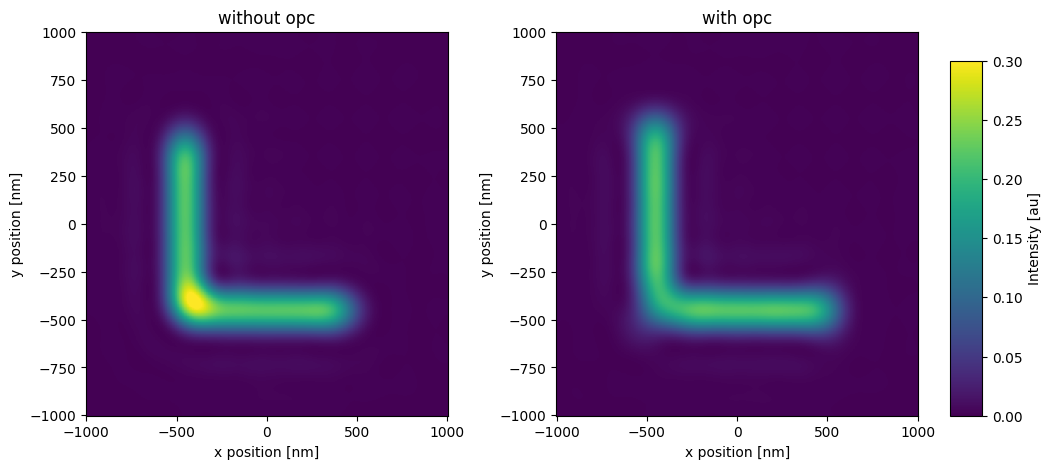

In [55]:
plt.subplot(1,2,1)
plt.title('without opc')
plt.pcolor(x_grid,y_grid,aerial_image_L,vmin=0., vmax=0.3)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=0.8, wspace=0.3, hspace=0.3)
#plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.ylabel('y position [nm]')


plt.subplot(1,2,2)
plt.title('with opc')
plt.pcolor(x_grid,y_grid,aerial_image_L_opc,vmin=0., vmax=0.3)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=0.8, wspace=0.3, hspace=0.3)
#plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.ylabel('y position [nm]')
cax = plt.axes([1.35, 0.0, 0.05, 0.74])
plt.colorbar(cax=cax,label = 'Intensity [au]')

plt.show()